In [1]:
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

2023-08-08 16:59:35.540882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:59:35.998906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1.模型整体保存

2.模型代码保存

3.模型权重保存

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

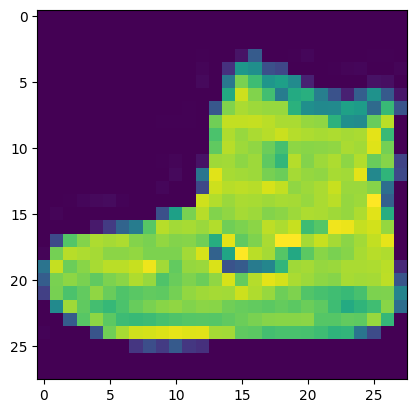

In [3]:
plt.imshow(train_images[0])

In [4]:
# 归一化处理
train_images = train_images/255.0
test_images = test_images/255.0

In [5]:
train_images.shape

(60000, 28, 28)

---

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

2023-08-08 16:59:24.685962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 16:59:24.705379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-08 16:59:24.705510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
model.fit(train_images, train_labels, epochs=10)

In [ ]:
model.evaluate(test_images, test_labels, verbose=0)

## 保存整个模型
(权重值，模型架构，优化器配置)

In [ ]:
model.save('less_model.h5')

In [ ]:
new_model = tf.keras.models.load_model('less_model.h5')

In [ ]:
new_model.summary()

In [ ]:
new_model.evaluate(test_images, test_labels, verbose=0)

## 仅保存架构
（只保存模型架构，无需保存权重以及优化器）

In [ ]:
json_config = model.to_json()

In [ ]:
json_config

In [ ]:
reinitialized_model = tf.keras.models.model_from_json(json_config)

In [ ]:
reinitialized_model.summary()

In [ ]:
# 只保存架构，没有权重值，无法直接使用
reinitialized_model.evaluate(test_images, test_labels, verbose=0)

In [ ]:
reinitialized_model.compile(optimizer='adam',
                            loss='sparse_categorical_crossentropy',
                            metrics=['acc'])

In [ ]:
reinitialized_model.evaluate(test_images, test_labels, verbose=0)

## 仅保存权重

In [ ]:
weight = model.get_weights()

In [ ]:
# weight

In [ ]:
reinitialized_model.set_weights(weight)
reinitialized_model.load_weights('less_weight.h5')

In [ ]:
reinitialized_model.evaluate(test_images, test_labels, verbose=0)

In [ ]:
model.save_weights('less_weight.h5')

## 训练期间保存检查点

In [ ]:
checkpoint_path = 'training_cp.cpkt'

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True)
# 这里设置save_weights_only=true，只保存权重，若为False，则保存全部

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
# 加载权重
model.load_weights(checkpoint_path)

In [ ]:
model.fit(train_images, train_labels, epochs=3, callbacks=[cp_callback])

In [ ]:
model.evaluate(test_images, test_labels, verbose=0)

## 自定义训练中保存检查点

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [9]:
optimizer = tf.keras.optimizers.Adam()#定义优化函数
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)#定义损失函数

In [10]:
def loss(model, x, y):
    y_ = model(x)
    return loss_func(y, y_)

In [11]:
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = loss_func(labels, pred)
    grads = t.gradient(loss_step, model.trainable_variables)#计算梯度
    optimizer.apply_gradients(zip(grads, model.trainable_variables))#优化参数
    train_loss(loss_step)
    train_accuracy(labels, pred)

In [12]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [14]:
dataset=dataset.shuffle(1000).batch(32)

In [15]:
import os
cp_dir = './customtrain_cp'
cp_prefix = os.path.join(cp_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

**注意**
在自定义训练中，可以在该位置添加'@tf.function'来调用tensorflow图运算加快计算过程

In [34]:
# @tf.function
def train():
    for epoch in range(5):
        for(batch, (image, labels)) in enumerate(dataset):
            train_step(model, image, labels)
        print("Epoch:{} loss:{}".format(epoch, train_loss.result()))
        print("Epoch:{} acc:{}".format(epoch, train_accuracy.result()))
        print()
        train_loss.reset_states()
        train_accuracy.reset_states()
        if(epoch+1) % 2 == 0:
            checkpoint.save(file_prefix=cp_prefix)

In [35]:
train()

Epoch:0 loss:0.26672351360321045
Epoch:0 acc:0.9009000062942505

Epoch:1 loss:0.25314271450042725
Epoch:1 acc:0.9061833620071411

Epoch:2 loss:0.24496549367904663
Epoch:2 acc:0.9076833128929138

Epoch:3 loss:0.23495687544345856
Epoch:3 acc:0.9126666784286499

Epoch:4 loss:0.22666707634925842
Epoch:4 acc:0.9147499799728394



In [17]:
tf.train.latest_checkpoint(cp_dir)#查看最新检查点

'./customtrain_cp/ckpt-4'

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(cp_dir))#根据weight名称恢复模型

In [22]:
tf.argmax(model(train_images,training=False),axis=-1).numpy()

array([9, 0, 0, ..., 3, 0, 5])

In [23]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [24]:
#计算准确率
(tf.argmax(model(train_images,training=False),axis=-1).numpy() == train_labels).sum()/len(train_labels)

0.9072666666666667